# Differentiable Renderer Examples

This notebook provides a simple demonstration of how to use both the JAX and PyTorch differentiable renderers. We will:
1. Define a set of circle parameters.
2. Render an image from these parameters.
3. Compute a gradient of the rendering loss with respect to the circle parameters.

## JAX Example

In [1]:
import jax
import jax.numpy as jnp
from jax import grad
from PIL import Image
import numpy as onp

from renderer_jax import render, mse_loss

# Configuration
IMG_SIZE = 64
NUM_CIRCLES = 10

### 1. Define Circle Parameters

In [2]:
# Each circle has 7 parameters: 
# (cx, cy, radius, r, g, b, alpha)
# We'll use random logits as our parameters.
key = jax.random.PRNGKey(42)
circle_params = jax.random.uniform(key, (NUM_CIRCLES, 7), minval=-1.0, maxval=1.0)

### 2. Render an Image

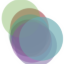

In [3]:
# Render the circles to create an image
rendered_image_jax = render(circle_params, IMG_SIZE, IMG_SIZE)

# Convert to a displayable format and show
img_to_show = onp.clip((rendered_image_jax + 1.0) * 127.5, 0, 255).astype(onp.uint8)
Image.fromarray(img_to_show)

### 3. Differentiate Through the Renderer

In [4]:
# Create a dummy target image (e.g., all black)
target_image_jax = jnp.full((IMG_SIZE, IMG_SIZE, 3), -1.0)

# Define a function to compute the loss
def loss_fn(params):
    return mse_loss(params, target_image_jax, IMG_SIZE, IMG_SIZE)

# Use jax.grad to get the gradient function
grad_fn = grad(loss_fn)

# Compute the gradients of the loss with respect to the circle parameters
gradients_jax = grad_fn(circle_params)

print("Shape of gradients:", gradients_jax.shape)
print("First 5 gradients for the first circle:\n", gradients_jax[0, :5])

Shape of gradients: (10, 7)
First 5 gradients for the first circle:
 [-0.02287949 -0.00747498 -0.01774527  0.02609978  0.02925749]


---

## PyTorch Example

In [5]:
import torch
from PIL import Image
import numpy as onp

from renderer_torch import render as render_torch, mse_loss as mse_loss_torch

# Configuration
IMG_SIZE = 64
NUM_CIRCLES = 10

### 1. Define Circle Parameters

In [9]:
# We need to set requires_grad=True to track gradients
torch.manual_seed(42)
circle_params_torch = torch.rand((NUM_CIRCLES, 7), requires_grad=True) * 2.0 - 1.0
circle_params_torch.retain_grad()

### 2. Render an Image

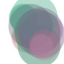

In [10]:
# Render the circles
rendered_image_torch = render_torch(circle_params_torch, IMG_SIZE, IMG_SIZE)

# Convert to a displayable format and show
img_to_show_torch = onp.clip((rendered_image_torch.detach().cpu().numpy() + 1.0) * 127.5, 0, 255).astype(onp.uint8)
Image.fromarray(img_to_show_torch)

### 3. Differentiate Through the Renderer

In [11]:
# Create a dummy target image
target_image_torch = torch.full((IMG_SIZE, IMG_SIZE, 3), -1.0)

# Calculate the loss
loss = mse_loss_torch(rendered_image_torch, target_image_torch)

# Backpropagate to compute gradients
loss.backward()

# The gradients are now stored in .grad attribute of the tensor
gradients_torch = circle_params_torch.grad

print("Shape of gradients:", gradients_torch.shape)
print("First 5 gradients for the first circle:\n", gradients_torch[0, :5])

Shape of gradients: torch.Size([10, 7])
First 5 gradients for the first circle:
 tensor([-0.0133, -0.0340, -0.0055,  0.0226,  0.0222])
